In [ ]:
# Percentile profiles across replicate subsets
import re
from pathlib import Path
import numpy as np
import pandas as pd

# ---------- Config ----------
PROFILES_CSV = r'3C_HQNO_concentration_profiles.csv'   # produced by your script above
OUT_DIR = Path('hqno_bin_percentiles')
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Define any number of replicate subsets (by replicate number).
# Use None or an empty set to include ALL replicates.
REPLICATE_SUBSETS = {
    "all": None,          # all replicates
    "rep_4_5_7": {4, 5, 7},    # example subset
    # "rep_1_4_5": {1, 4, 5},
}

STATUS_REQUIRE = "success"     # only include bins from successful fits
CONC_COL = "estimated_hqno_concentration"
YBIN_COL = "y_bin"
XPHYS_COL = "x_physical"       # optional; will be summarized as median per bin

# ---------- Helpers ----------
def extract_repl_num(x):
    """Parse replicate number from values like 4, '4', 'R4', 'rep4', 'replicate_4'."""
    if pd.isna(x):
        return np.nan
    m = re.search(r'\d+', str(x))
    return int(m.group()) if m else np.nan

def nanpercentile(a, q):
    a = pd.to_numeric(pd.Series(a), errors='coerce').to_numpy(float)
    a = a[np.isfinite(a)]
    return np.nan if a.size == 0 else float(np.percentile(a, q))

def summarize_subset(df_profiles: pd.DataFrame, subset_name: str, subset_nums: set[int] | None) -> pd.DataFrame:
    d = df_profiles.copy()

    # keep successful fits only (if present)
    if "status" in d.columns and STATUS_REQUIRE is not None:
        d = d[d["status"] == STATUS_REQUIRE].copy()

    # parse replicate numbers and filter
    d["replicate_num"] = d["replicate"].map(extract_repl_num)
    if subset_nums:
        d = d[d["replicate_num"].isin(subset_nums)].copy()

    # valid concentrations only
    d[CONC_COL] = pd.to_numeric(d[CONC_COL], errors='coerce')
    d = d[np.isfinite(d[CONC_COL])].copy()

    if d.empty:
        return pd.DataFrame(columns=["subset","replicates_used",YBIN_COL,XPHYS_COL,"n","p20","p50","p80"])

    # group per bin; pool across positions/replicates
    def agg_fn(g: pd.DataFrame) -> pd.Series:
        return pd.Series({
            "n": int(g[CONC_COL].notna().sum()),
            "p20": nanpercentile(g[CONC_COL], 20),
            "p50": nanpercentile(g[CONC_COL], 50),
            "p80": nanpercentile(g[CONC_COL], 80),
            # x_physical may repeat; take median for stability
            XPHYS_COL: float(np.nanmedian(pd.to_numeric(g.get(XPHYS_COL, pd.Series(np.nan)), errors='coerce'))) \
                       if XPHYS_COL in g.columns else np.nan
        })

    out = (d.groupby(YBIN_COL, dropna=False)
             .apply(agg_fn)
             .reset_index())

    # add metadata columns
    reps_used = sorted(set(d["replicate_num"].dropna().astype(int).tolist()))
    out.insert(0, "subset", subset_name)
    out.insert(1, "replicates_used", ",".join(map(str, reps_used)))
    # order columns
    out = out[["subset","replicates_used",YBIN_COL,XPHYS_COL,"n","p20","p50","p80"]]
    # sort by bin
    out = out.sort_values(by=YBIN_COL, kind="mergesort").reset_index(drop=True)
    return out

# ---------- Main ----------
dfp = pd.read_csv(PROFILES_CSV)

all_outputs = []
for name, subset in REPLICATE_SUBSETS.items():
    res = summarize_subset(dfp, name, subset)
    out_path = OUT_DIR / f"bin_percentiles_{name}.csv"
    res.to_csv(out_path, index=False)
    print(f"[ok] Saved {out_path} ({len(res)} rows).")
    all_outputs.append(res)

# combined file across all subsets (tidy format)
if all_outputs:
    combined = pd.concat(all_outputs, ignore_index=True)
    combined_path = OUT_DIR / "bin_percentiles_all_subsets.csv"
    combined.to_csv(combined_path, index=False)
    print(f"[ok] Combined CSV saved to {combined_path}")
else:
    print("[warn] No outputs were generated; check filters and input file.")



[ok] Saved hqno_bin_percentiles\bin_percentiles_all.csv (30 rows).
[ok] Saved hqno_bin_percentiles\bin_percentiles_rep_4_5_7.csv (30 rows).
[ok] Combined CSV saved to hqno_bin_percentiles\bin_percentiles_all_subsets.csv


C:\Users\raachben\AppData\Local\Temp\ipykernel_10384\3954342746.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_fn)
C:\Users\raachben\AppData\Local\Temp\ipykernel_10384\3954342746.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_fn)


: 

C:\Users\raachben\AppData\Local\Temp\ipykernel_10384\3282754061.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for subset, g in df.groupby("subset"):


Saved plot to: hqno_bin_percentiles\bin_percentile_bands.png


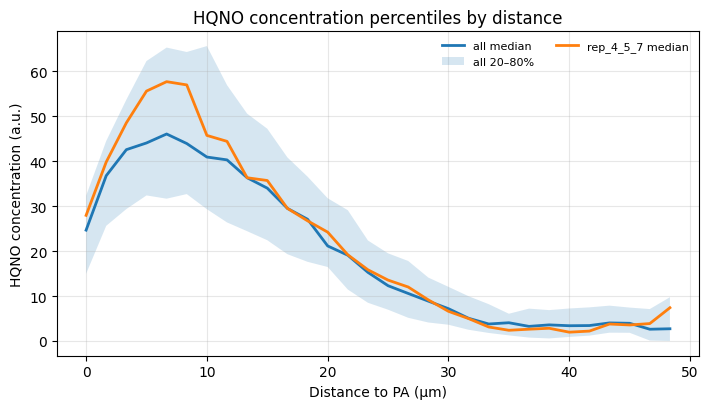

In [9]:
# --- Quick visualization of bin-wise percentiles (all subsets) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

IN_DIR = Path("hqno_bin_percentiles")
COMBINED = IN_DIR / "bin_percentiles_all_subsets.csv"

# If you want to plot only some subsets, list them here (or set to None for all)
SUBSETS_TO_PLOT = None              # e.g., ["all", "rep_2_3"]
FILL_BANDS_FOR  = "all"             # which subset should show the 20–80% ribbon (or set to None)

df = pd.read_csv(COMBINED)

# Filter subsets if requested
if SUBSETS_TO_PLOT:
    df = df[df["subset"].isin(SUBSETS_TO_PLOT)].copy()
    df["subset"] = pd.Categorical(df["subset"], SUBSETS_TO_PLOT, ordered=True)
else:
    order = sorted(df["subset"].unique().tolist())
    if "all" in order:
        order = ["all"] + [s for s in order if s != "all"]
    df["subset"] = pd.Categorical(df["subset"], order, ordered=True)

# Choose x-axis: prefer x_physical if present/finite, else y_bin
use_x_phys = ("x_physical" in df.columns) and np.isfinite(pd.to_numeric(df["x_physical"], errors="coerce")).any()
xcol = "x_physical" if use_x_phys else "y_bin"
xlabel = "Distance to PA (µm)" if xcol == "x_physical" else "Distance to PA (bins)"

plt.figure(figsize=(7.2, 4.2))
ax = plt.gca()

for subset, g in df.groupby("subset"):
    g = g.sort_values(xcol)
    x   = pd.to_numeric(g[xcol], errors="coerce").to_numpy(float)
    p20 = pd.to_numeric(g["p20"],  errors="coerce").to_numpy(float)
    p50 = pd.to_numeric(g["p50"],  errors="coerce").to_numpy(float)
    p80 = pd.to_numeric(g["p80"],  errors="coerce").to_numpy(float)

    # Median line
    ax.plot(x, p50, lw=2, label=f"{subset} median")

    # Light ribbon for one reference subset (to avoid clutter)
    if FILL_BANDS_FOR and str(subset) == FILL_BANDS_FOR:
        ax.fill_between(x, p20, p80, alpha=0.18, label=f"{subset} 20–80%")

ax.set_xlabel(xlabel)
ax.set_ylabel("HQNO concentration (a.u.)")
ax.set_title("HQNO concentration percentiles by distance")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=8, frameon=False)
plt.tight_layout()

out_png = IN_DIR / "bin_percentile_bands.png"
plt.savefig(out_png, dpi=200)
print(f"Saved plot to: {out_png}")
plt.show()
